# Spam Email Detection using RoBERTa

In [ ]:
# Prepare workplace
!pip install datasets transformers

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import numpy as np
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer


# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure NLTK dependencies are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Setting random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Model

In [ ]:
# Download Roberta from HuggingFace
model_name = 'FacebookAI/roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Move model to the specified device
model.to(device)

def tokenize_function(examples):
    return tokenizer(examples['processed_text'], padding="max_length", truncation=True)

NameError: name 'RobertaTokenizer' is not defined

# Dataset

In [ ]:
# Load and prepare the dataset
data_dir = 'enron_spam_data.csv'
email_data = pd.read_csv(data_dir)

# Rename columns
email_data = email_data.rename(columns={"Message ID": "mail_id", "Message": "text", "Subject": "subject"})

# Label encoding
label_encoder = LabelEncoder()
email_data['label'] = label_encoder.fit_transform(email_data['Spam/Ham'])

# Drop date
email_data = email_data.drop(columns=['Date', 'Spam/Ham'])

# Replace NaN values with empty strings
email_data = email_data.fillna('')

# Combine subject and text into a single column
email_data['combined_text'] = email_data['subject'] + " " + email_data['text']

In [ ]:
# Create a subset with equal number of Spam and Ham
SUBSET_SIZE = 4000

print(f"SPAM={len(email_data[email_data['label'] == 1])} | HAM={len(email_data[email_data['label'] == 0])}")
spam_data = email_data[email_data['label'] == 1].sample(n=SUBSET_SIZE//2, random_state=SEED)
ham_data = email_data[email_data['label'] == 0].sample(n=SUBSET_SIZE//2, random_state=SEED)
email_data = pd.concat([spam_data, ham_data])
print(f"SPAM={len(email_data[email_data['label'] == 1])} | HAM={len(email_data[email_data['label'] == 0])}")

SPAM=17171 | HAM=16545
SPAM=2000 | HAM=2000


In [ ]:
# Preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Cleans the text by removing special characters, converting to lowercase,
    and removing stopwords.
    """
    # Remove special characters and digits, make lowercase, and split by words
    words = re.findall(r'\b\w+\b', text.lower())
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to each email in the dataset
email_data['processed_text'] = email_data['combined_text'].apply(preprocess_text)

# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(email_data)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Split the dataset
tokenized_datasets = tokenized_datasets.train_test_split(test_size=0.2)

email_data.head()

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

,mail_id,subject,text,label,combined_text,processed_text
15751,15751,webmaster international cell phone opportunity...,lowest worldwide rates available anywhere on t...,1,webmaster international cell phone opportunity...,webmaster international cell phone opportunity...
10551,10551,wallstreet pulse,"good day to all broker ' s , day trader ' s an...",1,"wallstreet pulse good day to all broker ' s , ...",wallstreet pulse good day broker day trader in...
20504,20504,fda approved drug lasts 8 x longer than vi - a...,body bgcolor = blacktable cellpadding = 10 bor...,1,fda approved drug lasts 8 x longer than vi - a...,fda approved drug lasts 8 x longer vi ag ra bo...
18941,18941,"receive big discounts on ms windows xp , offic...",microsoft windows xp professional 2002 $ 50 al...,1,"receive big discounts on ms windows xp , offic...",receive big discounts ms windows xp office ado...
30237,30237,more and more choices for you all at affordabl...,objectbuilder amphigamae\nalbertville amdahlcs...,1,more and more choices for you all at affordabl...,choices affordable price melange objectbuilder...


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]  # Disable W&B logging
)

# Define a function to compute metrics
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='binary')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Save the model
model.save_pretrained('./spam_detection_model')
tokenizer.save_pretrained('./spam_detection_model')

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.127043,0.972500,0.971649,0.966667,0.976684
2,0.186600,0.098292,0.980000,0.979328,0.976804,0.981865
3,0.053700,0.126974,0.980000,0.979434,0.971939,0.987047


('./spam_detection_model/tokenizer_config.json',
 './spam_detection_model/special_tokens_map.json',
 './spam_detection_model/vocab.json',
 './spam_detection_model/merges.txt',
 './spam_detection_model/added_tokens.json')

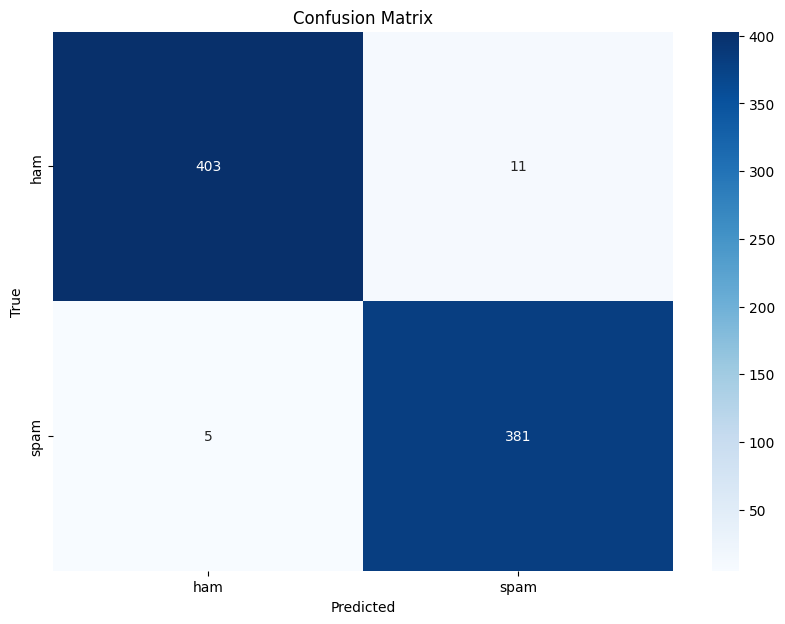

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

# Make predictions on the evaluation dataset
predictions = trainer.predict(tokenized_datasets['test']).predictions
predicted_labels = np.argmax(predictions, axis=1)
true_labels = tokenized_datasets['test']['label']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()